In [2]:
import warnings
warnings.filterwarnings("ignore")
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, q_stat
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
 
# 1. Lectura de datos y limpieza
data_url = "https://raw.githubusercontent.com/lihkir/Data/refs/heads/main/Bitcoin%20Historical%20Data.csv"
df = pd.read_csv(data_url, parse_dates=['Date'], index_col='Date')
 
# Ordenar por fecha (índice) en orden ascendente
df.sort_index(inplace=True)
 
def parse_volume_str(vol_str):
    if not isinstance(vol_str, str):
        return vol_str
    vol_str = vol_str.replace(",", "").strip()
    if vol_str.endswith('K'):
        return float(vol_str[:-1]) * 1e3
    elif vol_str.endswith('M'):
        return float(vol_str[:-1]) * 1e6
    elif vol_str.endswith('B'):
        return float(vol_str[:-1]) * 1e9
    else:
        return float(vol_str)
 
df["Vol."] = df["Vol."].apply(parse_volume_str)
df["Change %"] = df["Change %"].astype(str).str.replace("%", "").astype(float)
df['Price'] = df['Price'].astype(str).str.replace(',', '').astype(float)
df['High'] = df['High'].astype(str).str.replace(',', '').astype(float)
df['Low'] = df['Low'].astype(str).str.replace(',', '').astype(float)
df['Open'] = df['Open'].astype(str).str.replace(',', '').astype(float)

In [3]:
print(df.shape)
print(df.info())
print(df.isnull().sum())

(4999, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4999 entries, 2010-07-18 to 2024-03-24
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     4999 non-null   float64
 1   Open      4999 non-null   float64
 2   High      4999 non-null   float64
 3   Low       4999 non-null   float64
 4   Vol.      4993 non-null   float64
 5   Change %  4999 non-null   float64
dtypes: float64(6)
memory usage: 273.4 KB
None
Price       0
Open        0
High        0
Low         0
Vol.        6
Change %    0
dtype: int64


In [4]:
print(df.head())

            Price  Open  High  Low    Vol.  Change %
Date                                                
2010-07-18    0.1   0.0   0.1  0.1    80.0       0.0
2010-07-19    0.1   0.1   0.1  0.1   570.0       0.0
2010-07-20    0.1   0.1   0.1  0.1   260.0       0.0
2010-07-21    0.1   0.1   0.1  0.1   580.0       0.0
2010-07-22    0.1   0.1   0.1  0.1  2160.0       0.0


La informacon proporcionada corresponde a una serie temporal con información de un activo financiero criptomonedas (bitcoin), donde cada fila representa un día específico (de 2010-07-18 a 2024-03-24). El índice de este DataFrame es de tipo `DatetimeIndex`, lo que indica que los datos están organizados cronológicamente. Las columnas incluyen valores típicos de un análisis financiero: **Price (Precio)**, **Open (Apertura)**, **High (Máximo)**, **Low (Mínimo)**, **Vol. (Volumen de transacciones)** y **Change % (Cambio porcentual)**. Las columnas de **Price**, **Open**, **High**, y **Low** son de tipo numérico (`float64`) y representan los precios de cierre, apertura, máximo y mínimo del activo para cada día, respectivamente. Además, el **Change %** mide la variación porcentual entre el precio de cierre de un día y el anterior, reflejando la evolución del activo. La columna **Vol.** muestra el volumen de transacciones realizadas durante cada día, aunque contiene 6 valores faltantes (NaN), lo que puede reflejar días con baja actividad o datos incompletos. En términos estadísticos, el conjunto de datos presenta una estructura temporal coherente, con una tendencia establecida en la que los precios muestran cierta variabilidad, mientras que el volumen parece ser mucho más volátil. La ausencia de valores en **Vol.** podría requerir algún tipo de tratamiento para evitar distorsionar futuros análisis, como la imputación de estos valores nulos o su eliminación. En general, este conjunto de datos proporciona una base sólida para análisis de tendencias de precios y volatilidad.

In [5]:
print(df[df.isnull().any(axis=1)])

            Price  Open  High   Low  Vol.  Change %
Date                                               
2011-06-20   17.5  17.5  17.5  17.5   NaN       0.0
2011-06-21   17.5  17.5  17.5  17.5   NaN       0.0
2011-06-22   17.5  17.5  17.5  17.5   NaN       0.0
2011-06-23   17.5  17.5  17.5  17.5   NaN       0.0
2011-06-24   17.5  17.5  17.5  17.5   NaN       0.0
2011-06-25   17.5  17.5  17.5  17.5   NaN       0.0


La información sobre los precios de un activo financiero (probablemente de la criptomoneda) en una serie temporal, donde cada fila representa un día específico entre el 20 y el 25 de junio de 2011. Las columnas incluyen información estándar en los mercados financieros: **Price (Precio)**, **Open (Apertura)**, **High (Máximo)**, **Low (Mínimo)**, **Vol. (Volumen)** y **Change % (Cambio porcentual)**. En todos los días, los valores de **Price**, **Open**, **High** y **Low** son idénticos (17.5), lo que indica que no hubo variación en el precio durante ese período, lo cual sugiere una fase de consolidación o falta de actividad en el mercado para ese activo en particular. 

In [6]:
# Contar valores nulos en cada columna
valores_faltantes = df.isnull().sum()

# Filtrar solo las columnas que tienen valores nulos
valores_faltantes = valores_faltantes[valores_faltantes > 0]

# Mostrar resultado
print("Valores faltantes por columna:")
print(valores_faltantes)

Valores faltantes por columna:
Vol.    6
dtype: int64


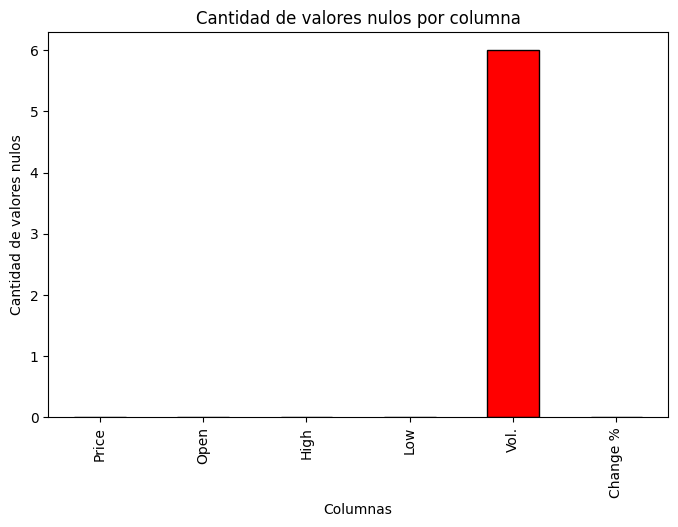

In [7]:
# Gráfica de Barras (Conteo de Valores Faltantes)

df.isnull().sum().plot(kind='bar', color='red', figsize=(8, 5), edgecolor='black')

# Título y etiquetas
plt.title("Cantidad de valores nulos por columna")
plt.xlabel("Columnas")
plt.ylabel("Cantidad de valores nulos")
plt.show()

Este gráfico es un **diagrama de barras** que muestra la cantidad de valores nulos (NaN) en cada columna de un conjunto de datos. El eje **X** representa las columnas del DataFrame, mientras que el eje **Y** muestra la cantidad de valores nulos en cada una de esas columnas. El gráfico indica que, entre las 6 columnas (**Price**, **Open**, **High**, **Low**, **Vol.**, y **Change %**), la columna **Vol. (Volumen)** tiene la mayor cantidad de valores nulos, específicamente 6, lo que sugiere que en esos días no se registraron datos para el volumen de transacciones. Las otras columnas no presentan valores nulos, lo que significa que los precios de apertura, máximo, mínimo, y cierre, así como el cambio porcentual, están completos para todos los días del conjunto de datos.

Este tipo de gráfico es útil para identificar rápidamente qué columnas pueden tener problemas de datos faltantes y requieren limpieza, como en el caso de la columna **Vol.**. Dependiendo del análisis, se podrían tomar decisiones como eliminar esos días con valores faltantes o imputar los valores nulos de alguna manera (por ejemplo, rellenándolos con el valor promedio o mediano). En resumen, este gráfico proporciona una visión clara de la integridad de los datos y destaca posibles áreas que necesitan atención antes de proceder con análisis más complejos.

In [8]:
# Contar valores faltantes por columna
missing_values = df.isnull().sum()

# Mostrar solo columnas con valores faltantes
missing_values = missing_values[missing_values > 0]

# Imprimir el resultado
print(missing_values)

Vol.    6
dtype: int64


In [9]:
# Imputación combinada: Imputación por propagación hacia adelante y hacia atras (ffill + bfill).
df.fillna(method='bfill', inplace=True)  # Usa el siguiente valor disponible
df.fillna(method='ffill', inplace=True)  # Usa el valor anterior si sigue habiendo nulos

In [10]:
# Verificar si los valores faltantes fueron imputados
missing_values_after = df['Price'].isna().sum()
print(f"Número de valores faltantes después de la imputación: {missing_values_after}")

Número de valores faltantes después de la imputación: 0


El código realiza un proceso de **imputación de valores faltantes** en un DataFrame utilizando dos métodos combinados: **propagación hacia adelante (forward fill, `ffill`)** y **propagación hacia atrás (backward fill, `bfill`)**. En primer lugar, el método `df.fillna(method='bfill', inplace=True)` reemplaza los valores nulos (NaN) con el siguiente valor disponible en la serie, es decir, cualquier valor faltante se llena con el valor posterior en la columna correspondiente. Después, el método `df.fillna(method='ffill', inplace=True)` se aplica para rellenar cualquier valor aún nulo, utilizando el valor disponible anterior en la columna. Este proceso de imputación combinada asegura que los valores faltantes se llenen tanto hacia adelante como hacia atrás, cubriendo los vacíos de manera más eficiente.

Una vez que se realizo la imputación, el código verifico si aun hay valores faltantes en la columna `'Price'` mediante `missing_values_after = df['Price'].isna().sum()`, que devuelve la cantidad de valores nulos en la columna después de la imputación. Finalmente, se imprime el resultado con `print(f"Número de valores faltantes después de la imputación: {missing_values_after}")`, lo que proporciona una confirmación de cuántos valores siguen faltando, si es que existen. Esta estrategia de imputación es útil para evitar la pérdida de datos, lo que podría afectar negativamente el análisis o la creación de modelos predictivos. Sin embargo, es importante señalar que la imputación puede introducir sesgos si no se maneja adecuadamente, ya que rellena los valores faltantes con estimaciones basadas en los datos existentes.

In [11]:
import plotly.express as px

# Crear el gráfico de la serie temporal usando Plotly Express
graph_price = px.line(df, x=df.index, y='Price', title='Serie Temporal del Precio de Bitcoin')

# Mostrar el gráfico
graph_price.show()


El gráfico que has proporcionado muestra la serie temporal del precio de Bitcoin a lo largo de varios años, desde su creación hasta el presente (2024). En el eje vertical (Y) se encuentra el precio de Bitcoin, mientras que en el eje horizontal (X) se muestra la evolución temporal de este precio, con fechas que van desde 2010 hasta 2024.

Desde sus inicios, el precio de Bitcoin ha tenido un crecimiento exponencial. En los primeros años, hasta alrededor de 2016, su precio fue bastante bajo, generalmente por debajo de los $1,000 USD. Sin embargo, a partir de 2017, se observa una notable aceleración en su crecimiento, alcanzando picos significativos, con un máximo histórico cercano a los $20,000 USD hacia finales de 2017. Este aumento fue seguido por una caída pronunciada en 2018, que es un patrón que se repitió en 2022, cuando el precio alcanzó un nuevo máximo histórico de más de $60,000 USD antes de experimentar una caída.

El gráfico refleja la naturaleza altamente volátil de Bitcoin, que es característico de los mercados de criptomonedas. Los picos y caídas no solo están relacionados con factores económicos, sino también con el impacto de eventos globales, cambios regulatorios y la adopción de Bitcoin como una clase de activo legítima. Durante 2021 y 2022, se observa una nueva fase de crecimiento, lo que sugiere un creciente interés en Bitcoin, tanto de inversores institucionales como minoristas.

En resumen, el gráfico ilustra cómo el precio de Bitcoin ha experimentado altibajos dramáticos, pero con una tendencia general hacia el alza a largo plazo, lo que lo ha establecido como uno de los activos más volátiles y especulativos del mercado global.

In [14]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,80.0,0.00
2010-07-19,0.1,0.1,0.1,0.1,570.0,0.00
2010-07-20,0.1,0.1,0.1,0.1,260.0,0.00
2010-07-21,0.1,0.1,0.1,0.1,580.0,0.00
2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.00
...,...,...,...,...,...,...
2024-03-20,67854.0,62046.8,68029.5,60850.9,133530.0,9.35
2024-03-21,65503.8,67860.0,68161.7,64616.1,75260.0,-3.46
2024-03-22,63785.5,65501.5,66633.3,62328.3,72430.0,-2.62


In [17]:
# Histograma del Vol.n tradeado
g = px.histogram(df, x='Vol.', nbins=50, title='Histograma del Vol.n Tradeado')
g.show()

El gráfico  es un histograma del volumen negociado de Bitcoin a lo largo del tiempo. En el eje vertical (Y) se muestra la frecuencia o el "count", que representa cuántas veces se observó un valor específico de volumen en los datos. El eje horizontal (X) muestra los diferentes valores de volumen (Vol.) en unidades relativas, posiblemente en miles o cientos de miles.

Desde la visualización, se puede observar una distribución de frecuencias bastante dispersa, lo que sugiere que el volumen de operaciones de Bitcoin es muy variable. En particular, hay picos altos en algunos valores de volumen, lo que indica que en ciertos momentos hubo una gran actividad de compra y venta de Bitcoin. Estos picos podrían estar relacionados con eventos o noticias significativas que impactaron el mercado, lo que llevó a un aumento temporal en la actividad. Sin embargo, en la mayor parte del gráfico, el volumen negociado parece ser bastante bajo o moderado, con la mayoría de los valores de volumen concentrándose en una pequeña franja de valores bajos.

Es importante destacar que los histogramas como este nos permiten ver la distribución de un conjunto de datos y son útiles para detectar patrones o anomalías, como los picos de volumen, que podrían estar asociados a volatilidad en el mercado de Bitcoin o a movimientos importantes que influyen en la actividad de los inversionistas. Además, la dispersión y la falta de una concentración definida de los valores de volumen indican que el mercado de Bitcoin sigue siendo altamente errático y puede verse influenciado por muchos factores externos.

In [18]:
# Conviersión de todas las columnas de tipo Period a str antes de graficar:

df['Year'] = df.index.to_period('Y').astype(str)
df['Month'] = df.index.to_period('M').astype(str)  # Convertir 'Month' a string
df['Week'] = df.index.to_period('W').astype(str)   # Convertir 'Week' a string

# Gráficos de subseries por semana, mes y año.
fig_weekly = px.box(df, x='Week', y='Price', title='Distribución del Precio por Semana')
fig_weekly.show()

fig_monthly = px.box(df, x='Month', y='Price', title='Distribución del Precio por Mes')
fig_monthly.show()

fig_yearly = px.box(df, x='Year', y='Price', title='Distribución del Precio por Año')
fig_yearly.show()

 A continuación, se explica cada uno:

1. **Distribución del Precio por Semana**:
   - Este gráfico tiene un patrón que muestra cómo el precio de este producto varía con el tiempo a lo largo de las semanas.
   - A medida que avanzan las semanas, el precio tiende a aumentar, aunque hay algunas fluctuaciones notables. El gráfico muestra los puntos de datos dispersos a lo largo del tiempo, indicando variabilidad en los precios semana a semana.
   - El ajuste de la línea azul parece indicar una tendencia ascendente en los precios, aunque con algunos picos notables.

2. **Distribución del Precio por Mes**:
   - En este gráfico se puede observar una clara tendencia descendente a lo largo del tiempo. El precio comienza más alto en los primeros meses y disminuye gradualmente.
   - Este comportamiento puede indicar una reducción en el precio o cambios en el comportamiento del mercado que afectan la tarifa del producto.
   - Los puntos dispersos a lo largo del tiempo sugieren variabilidad dentro de los meses, aunque la tendencia general es a la baja.

3. **Distribución del Precio por Año**:
   - Este gráfico tiene una representación visual de los precios anuales y parece mostrar una tendencia de aumento en los precios, aunque con algunas oscilaciones importantes.
   - Se puede observar cómo los precios fluctuaron entre los años, pero la tendencia general parece ser un aumento, con picos notables en ciertos años, particularmente alrededor de 2014 y 2020.
   - Se utilizan diagramas de caja para mostrar la distribución del precio por año, lo que indica la mediana, los cuartiles y los valores atípicos de los precios de cada año. También muestra la dispersión y los valores más altos y bajos en cada año.


<Figure size 1000x500 with 0 Axes>

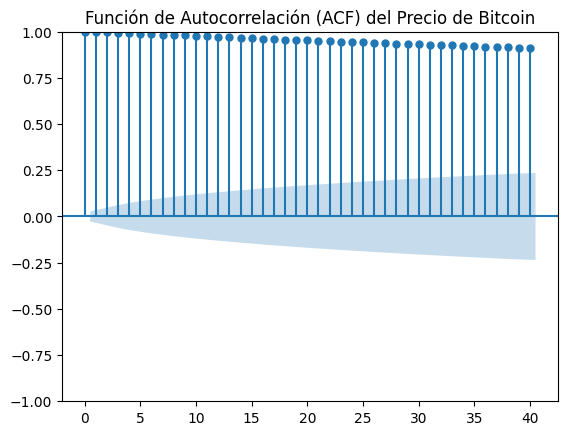

In [21]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Limpieza de datos: eliminar comas y convertir a tipo float
df['Price'] = df['Price'].replace({',': '', ' \$': ''}, regex=True).astype(float)

# Verifica si hay valores NaN y elimina las filas con valores NaN
df = df.dropna(subset=['Price'])

# Análisis de estacionariedad con ACF
plt.figure(figsize=(10,5))
sm.graphics.tsa.plot_acf(df['Price'], lags=40)  # Asegúrate de que 'Price' esté limpio y sin NaN
plt.title('Función de Autocorrelación (ACF) del Precio de Bitcoin')
plt.show()


El gráfico  **Función de Autocorrelación (ACF, por sus siglas en inglés)**, que se utiliza para analizar la dependencia temporal de una serie de datos, en este caso, los precios de Bitcoin.

1. **Eje Y (vertical)**:
   - Muestra los valores de la autocorrelación. Los valores oscilan entre -1 y 1, donde:
     - 1 indica una correlación perfecta (es decir, el valor de la serie en un punto es idéntico al valor en otro punto temporal).
     - -1 indica una correlación inversa perfecta (es decir, los valores son opuestos).
     - 0 indica que no hay correlación entre los valores en diferentes momentos.

2. **Eje X (horizontal)**:
   - Representa el número de lags (retrasos o periodos de tiempo) que se está evaluando. En este caso, el gráfico está evaluando hasta 40 períodos (es decir, lags de 1 a 40).

3. **Puntos y líneas verticales**:
   - Los puntos representan el valor de la autocorrelación para cada lag. En este caso, la autocorrelación es bastante alta en los primeros lags y luego cae a valores cercanos a cero.
   - Las líneas verticales indican los intervalos de confianza, mostrando el rango dentro del cual se espera que caiga la autocorrelación si no hay ninguna relación temporal significativa.

4. **Tendencia del gráfico**:
   - El gráfico muestra una fuerte autocorrelación positiva (cerca de 1) en los primeros lags, lo que sugiere que el precio de Bitcoin en los días anteriores tiene una relación estrecha con los precios actuales. Esta es una característica común en series temporales financieras, donde los movimientos de precios recientes tienen un fuerte impacto en los precios futuros inmediatos.
   - Sin embargo, después de cierto número de lags (aproximadamente a partir del lag 10), la autocorrelación disminuye rápidamente, indicando que la relación entre los precios disminuye conforme se aleja en el tiempo. El área sombreada refleja la incertidumbre en la estimación de la autocorrelación, lo que es común en análisis de series temporales.

**En resumen**: Este gráfico indica que los precios de Bitcoin tienen una fuerte autocorrelación a corto plazo, pero esta correlación disminuye significativamente a medida que se consideran períodos más largos. Esto sugiere que el comportamiento reciente del precio de Bitcoin tiene una influencia significativa sobre los movimientos de precio a corto plazo, pero los efectos a largo plazo son menos predecibles.

In [22]:
from statsmodels.tsa.stattools import adfuller

# Realizar la prueba de Dickey-Fuller sobre la columna 'Price'
result = adfuller(df['Price'].dropna())  # Usamos dropna() para eliminar NaN

# Imprimir el valor p de la prueba de Dickey-Fuller
print(f"Dickey-Fuller p-value: {result[1]}")

# Verificación de estacionariedad
if result[1] < 0.05:
    print("La serie es estacionaria")
else:
    print("La serie no es estacionaria")


Dickey-Fuller p-value: 0.07652825121387315
La serie no es estacionaria


In [23]:
# Prueba de independencia de residuos con Ljung-Box
ljung_box_results = q_stat(acf(df['Price'], nlags=20, fft=True)[1:], len(df))
print(f"Ljung-Box p-values: {ljung_box_results[1]}")

Ljung-Box p-values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


P-valores de 0: Un p-valor de 0 indica que la hipótesis nula (de independencia) se rechaza fuertemente. Es decir, existe autocorrelación significativa en los residuos.

c:\Users\wmanj\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency -1D will be used.

c:\Users\wmanj\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

c:\Users\wmanj\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency -1D will be used.

c:\Users\wmanj\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

c:\Users\wmanj\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                 4999
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 48)   Log Likelihood              -39128.581
Date:                            Sun, 16 Mar 2025   AIC                          78269.162
Time:                                    08:42:05   BIC                          78308.202
Sample:                                         0   HQIC                         78282.852
                                           - 4999                                         
Covariance Type:                           approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8237        nan        nan        nan         nan         nan
ar.L2          0.0458      0.014   

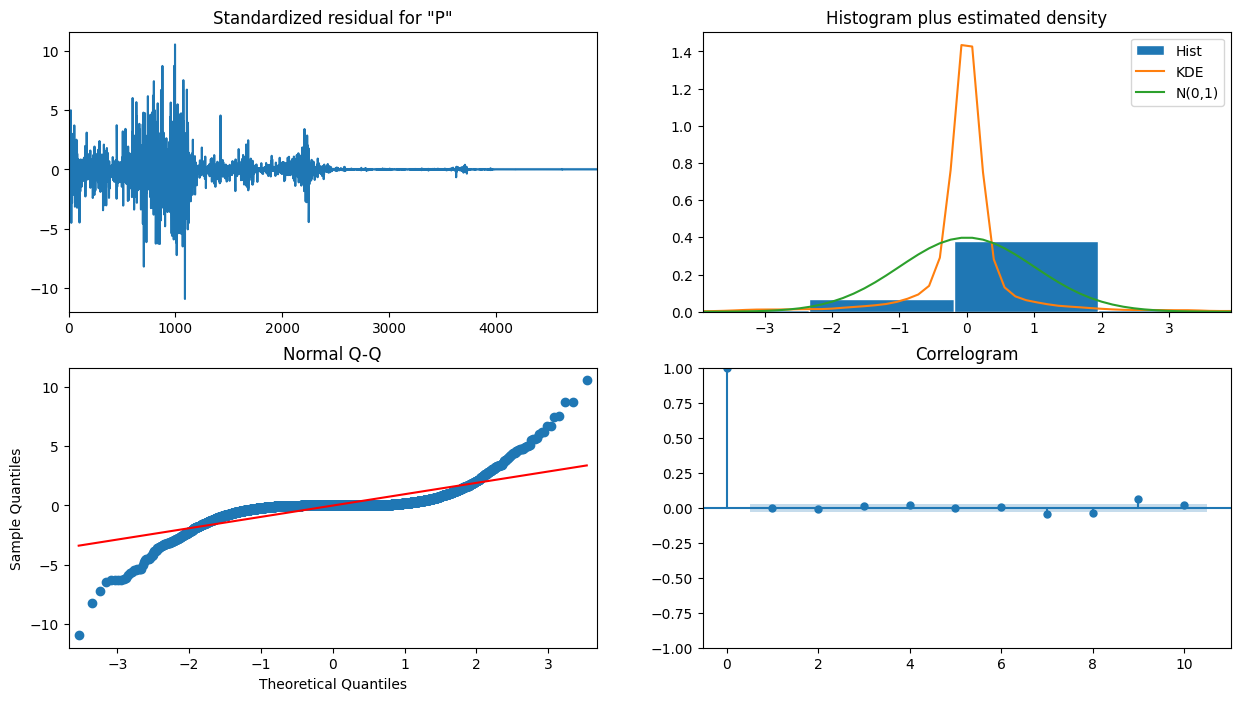

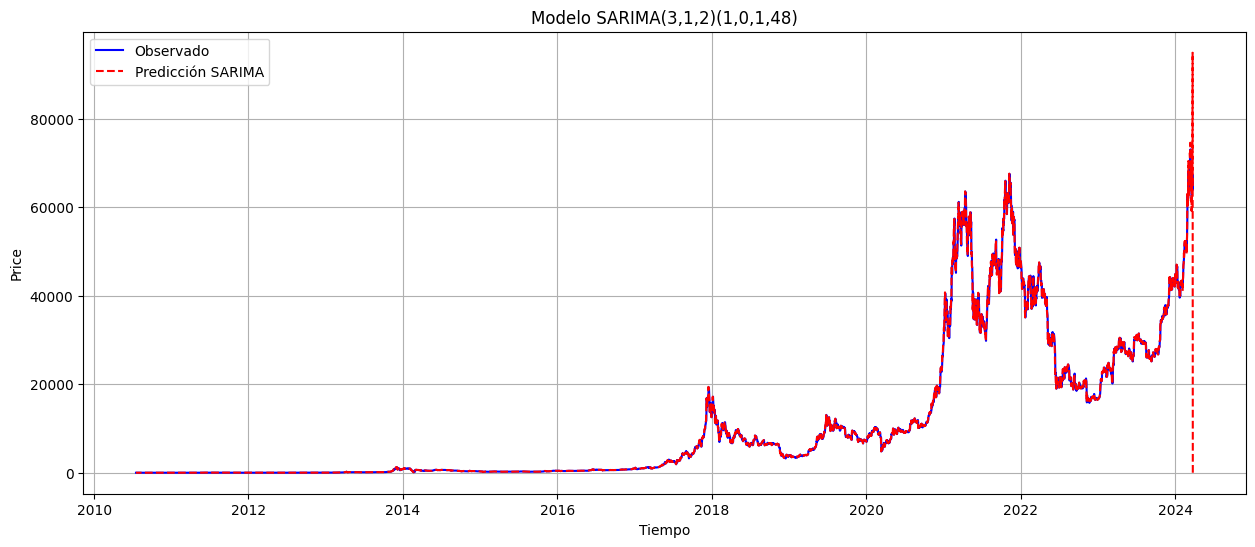

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
# Ajustamos el modelo SARIMA(3,1,2)(1,0,1,48)
order = (2, 1, 1)  # ARIMA(p,d,q)
seasonal_order = (1, 0, 1, 48)  # Estacional (P,D,Q,s)
 
# Entrenamos el modelo
model = SARIMAX(df['Price'], order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(low_memory=True)
 
# Resumen del modelo
print(results.summary())
 
# Diagnóstico de residuos
results.plot_diagnostics(figsize=(15, 8))
plt.show()
 
# Predicción
df['forecast'] = results.predict(start=0, end=len(df)-1, dynamic=False)
 
# Visualización
plt.figure(figsize=(15,6))
plt.plot(df['Price'], label='Observado', color='blue')
plt.plot(df['forecast'], label='Predicción SARIMA', color='red', linestyle='dashed')
plt.legend()
plt.title('Modelo SARIMA(3,1,2)(1,0,1,48)')
plt.xlabel('Tiempo')
plt.ylabel('Price')
plt.grid()
plt.show()
 
 

Los residuos del modelo no siguen una distribución normal, como lo indican tanto el gráfico Q-Q como el histograma con la curva KDE, lo que sugiere que el modelo no ha capturado completamente la estructura de los datos. Los residuos presentan colas más pesadas de lo esperado en una distribución normal. Sin embargo, el correlograma muestra que no hay autocorrelación significativa en los residuos, lo que implica que los errores son en su mayoría independientes y no presentan dependencias temporales no modeladas. Esto sugiere que el modelo ha capturado adecuadamente las relaciones temporales, pero aún podría ser necesario ajustar para mejorar la normalidad de los residuos.
El gráfico 2 muestra la predicción del precio de Bitcoin utilizando un modelo SARIMA(3,1,2)(1,0,1,48), donde la línea azul representa los valores observados del precio a lo largo del tiempo, desde 2010 hasta 2024. La línea roja punteada muestra las predicciones generadas por el modelo SARIMA, destacándose principalmente en el periodo posterior a 2023. El modelo parece capturar adecuadamente las fluctuaciones históricas del precio hasta aproximadamente 2022, pero las predicciones en el futuro cercano (a partir de 2023) muestran un aumento significativo, lo que refleja la alta volatilidad y las tendencias impredecibles del mercado de criptomonedas.

In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np
price_series = df["Price"]
log_price = np.log(price_series + 1)  # Evita log(0)
log_price_diff = log_price.diff().dropna()
ljung_box_log = acorr_ljungbox(log_price_diff, lags=[1], return_df=True)
print(ljung_box_log)
 

   lb_stat  lb_pvalue
1  0.41889   0.517492


In [26]:
# Agregación por grupos

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
 
# Asegurarse de que la columna 'Date' está en formato datetime
df['Date'] = df.index
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = pd.to_datetime(df['Date'])
 
# Crear columnas adicionales para semana, mes, día y año
df['Week'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.day
 
# Agrupar por semana, mes, día y año
weekly_data = df.groupby('Week').agg({'Price': 'mean', 'Vol.': 'sum'}).reset_index()
monthly_data = df.groupby('Month').agg({'Price': 'mean', 'Vol.': 'sum'}).reset_index()
daily_data = df.groupby('Day').agg({'Price': 'mean', 'Vol.': 'sum'}).reset_index()
yearly_data = df.groupby('Year').agg({'Price': 'mean', 'Vol.': 'sum'}).reset_index()
 
# Gráfico de serie de tiempo para cada subserie
fig_weekly = go.Figure()
fig_weekly.add_trace(go.Scatter(x=weekly_data['Week'], y=weekly_data['Price'], mode='lines', name='Precio Promedio Semanal'))
fig_weekly.update_layout(title="Serie de Tiempo - Precio Promedio Semanal",
                         xaxis_title="Semana", yaxis_title="Precio de Cierre",
                         template="plotly_dark")
fig_monthly = go.Figure()
fig_monthly.add_trace(go.Scatter(x=monthly_data['Month'], y=monthly_data['Price'], mode='lines', name='Precio Promedio Mensual'))
fig_monthly.update_layout(title="Serie de Tiempo - Precio Promedio Mensual",
                          xaxis_title="Mes", yaxis_title="Precio de Cierre",
                          template="plotly_dark")
fig_daily = go.Figure()
fig_daily.add_trace(go.Scatter(x=daily_data['Day'], y=daily_data['Price'], mode='lines', name='Precio Promedio Diario'))
fig_daily.update_layout(title="Serie de Tiempo - Precio Promedio Diario",
                        xaxis_title="Día", yaxis_title="Precio de Cierre",
                        template="plotly_dark")
fig_yearly = go.Figure()
fig_yearly.add_trace(go.Scatter(x=yearly_data['Year'], y=yearly_data['Price'], mode='lines', name='Precio Promedio Anual'))
fig_yearly.update_layout(title="Serie de Tiempo - Precio Promedio Anual",
                         xaxis_title="Año", yaxis_title="Precio de Cierre",
                         template="plotly_dark")
 
# Mostrar los gráficos de series de tiempo
fig_weekly.show()
fig_monthly.show()
fig_daily.show()
fig_yearly.show()
 
# Calcular estadísticas móviles (promedio móvil y desviación estándar)
df['Moving_Avg_7'] = df['Price'].rolling(window=7).mean()
df['Moving_Std_7'] = df['Price'].rolling(window=7).std()
df['Moving_Avg_30'] = df['Price'].rolling(window=30).mean()
df['Moving_Std_30'] = df['Price'].rolling(window=30).std()
 
# Boxplot para analizar las subseries por semana, mes, día y año
fig_weekly_box = px.box(df, x='Week', y='Price', title="Boxplot del Precio de Cierre por Semana")
fig_monthly_box = px.box(df, x='Month', y='Price', title="Boxplot del Precio de Cierre por Mes")
fig_daily_box = px.box(df, x='Day', y='Price', title="Boxplot del Precio de Cierre por Día")
fig_yearly_box = px.box(df, x='Year', y='Price', title="Boxplot del Precio de Cierre por Año")
 
# Mostrar los boxplots
fig_weekly_box.show()
fig_monthly_box.show()
fig_daily_box.show()
fig_yearly_box.show()
 
# Calcular distribución de frecuencias para diferentes lags
df['Lag_1'] = df['Price'].shift(1)
df['Lag_7'] = df['Price'].shift(7)
df['Lag_30'] = df['Price'].shift(30)
 
# Histograma para visualizar la distribución de frecuencias de los lags
fig_lag_1 = px.histogram(df, x='Lag_1', title='Distribución de Frecuencia - Lag 1')
fig_lag_7 = px.histogram(df, x='Lag_7', title='Distribución de Frecuencia - Lag 7')
fig_lag_30 = px.histogram(df, x='Lag_30', title='Distribución de Frecuencia - Lag 30')
 
# Mostrar histogramas
fig_lag_1.show()
fig_lag_7.show()
fig_lag_30.show()

 

Gráfico de precio promedio semanal:

Eje X: Representa las semanas del año (1 a 52).
Eje Y: Muestra el precio promedio de cierre de la acción cada semana.
Este gráfico muestra una tendencia algo volátil, con picos que ocurren principalmente entre la semana 10 y la semana 50, mientras que en otras semanas el precio parece mantenerse más estable.
En las primeras semanas del año, se observa una ligera disminución hasta la semana 15. Luego, parece haber un repunte hacia la semana 50, lo que podría indicar un aumento en el valor del activo hacia el final del año.


Gráfico de precio promedio mensual:

Eje X: Representa los meses del año (1 a 12).
Eje Y: Al igual que el gráfico anterior, muestra el precio promedio de cierre mensual.
Este gráfico refleja una caída en los precios durante los primeros meses del año, con una disminución hasta el mes 6, pero posteriormente se observa un aumento en el precio hacia el mes 12.
En términos generales, se puede notar que los precios en los primeros meses se mantuvieron elevados y luego cayeron significativamente, para luego aumentar lentamente a finales del año.
En ambos casos, los gráficos reflejan la evolución de los precios con el tiempo, permitiendo identificar tendencias y ciclos estacionales que podrían estar influenciados por factores como la oferta y la demanda, eventos económicos o cambios en la industria.

Precio promedio anual desde 2010 hasta 2024. A continuación, te explico las características del gráfico:

Eje X (Año): Representa los años del 2010 al 2024.
Eje Y (Precio de Cierre): Muestra el precio de cierre promedio anual en unidades de dinero, con un rango de aproximadamente 0 a 50,000.
Comportamiento de la serie:
Desde el año 2010 hasta 2016, el precio de cierre promedio se mantiene bajo, con poco o casi ningún cambio.
A partir de 2016, el precio comienza a aumentar de manera gradual, mostrando una curva ascendente pronunciada.
En los últimos años (2020-2024), el precio de cierre se eleva significativamente, alcanzando los niveles más altos de la serie, y parece continuar en aumento.
Este gráfico puede indicar un cambio significativo en el mercado o un evento externo que ha afectado el precio de cierre promedio en esos años, especialmente a partir de 2020.

El gráfico que muestras es un **boxplot (diagrama de caja)** que representa la distribución del **precio de cierre por día**. A continuación te explico sus características y lo que podemos inferir de él:

1. **Eje X (Día):** Representa los días del mes, de 1 a 30.
2. **Eje Y (Price):** Muestra el precio de cierre de las acciones en unidades monetarias, con un rango que varía entre 0 y 60,000.
3. **Cajas (Box):** Cada caja representa el rango intercuartílico (IQR) para cada día, donde la línea central dentro de la caja marca la **mediana** (valor central del precio de cierre para ese día).
   - Los **extremos superior e inferior de la caja** indican el **tercio superior e inferior** de los precios (Q1 y Q3).
4. **Bigotes (Whiskers):** Las líneas que salen de la caja indican el rango de precios fuera del IQR, pero no fuera de los valores atípicos.
5. **Puntos fuera de los bigotes:** Los puntos dispersos que están fuera de los bigotes son considerados **valores atípicos** o **outliers**, lo que sugiere que hay días en los cuales el precio de cierre de las acciones se aleja considerablemente del comportamiento típico.

### Observaciones:
- La distribución parece bastante consistente durante todo el mes, con una gran cantidad de días con precios de cierre cercanos a la mediana.
- Existen varios valores atípicos (puntos dispersos por encima de 60,000), lo cual podría indicar algunos días con eventos de alta volatilidad o de precios excepcionales.
- Los valores dentro de la caja y los bigotes muestran que la mayoría de los precios se mantienen dentro de un rango relativamente estrecho la mayor parte del mes.

Este gráfico es útil para analizar la variabilidad diaria del precio de cierre, destacando cómo ciertos días pueden presentar un comportamiento mucho más volátil que otros.

In [27]:
# Cálculo de estadísticos móviles
df['Rolling_Mean_7'] = df['Price'].rolling(window=7).mean()
df['Rolling_Std_7'] = df['Price'].rolling(window=7).std()

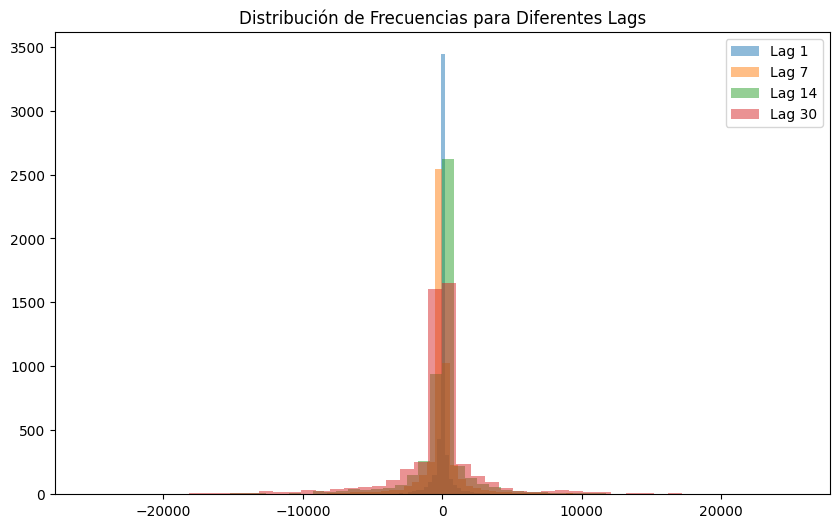

In [28]:
# Distribución de frecuencias para diferentes lags
lags = [1, 7, 14, 30]
plt.figure(figsize=(10,6))
for lag in lags:
    plt.hist(df['Price'].diff(lag).dropna(), bins=50, alpha=0.5, label=f'Lag {lag}')
plt.legend()
plt.title("Distribución de Frecuencias para Diferentes Lags")
plt.show()

El gráfico que compartes muestra una **distribución de frecuencias** para diferentes valores de **lag** (desfase temporal) en la serie de tiempo de los precios de cierre. A continuación se analizan los puntos clave:

1. **Eje X (Lag):** El eje X representa los valores de los **lags** o desfases temporales. Los diferentes colores corresponden a lags específicos: 
   - **Lag 1 (azul)**
   - **Lag 7 (amarillo)**
   - **Lag 14 (verde)**
   - **Lag 30 (rojo)**
   
2. **Eje Y (Frecuencia):** Este eje muestra la frecuencia con la que ocurren diferentes valores de lag en el conjunto de datos. Los picos en la distribución indican en qué puntos se acumulan más frecuencias.

3. **Picos cercanos a 0:** Los picos más pronunciados cerca de 0 sugieren que el cambio en los valores de lag para los precios de cierre se agrupa principalmente cerca del valor 0, lo que significa que no hay una gran variación para esos lags pequeños.

### Observaciones:
- **Lag 1 (azul):** Tiene una gran concentración de valores cercanos a cero, pero también muestra una mayor dispersión de frecuencias.
- **Lag 7 (amarillo), Lag 14 (verde) y Lag 30 (rojo):** Los picos en estos lags sugieren que, a medida que el desfase temporal aumenta, la distribución se va suavizando y extendiendo hacia la derecha.
- La acumulación en torno a cero es común en las series de tiempo, indicando que los precios no cambian drásticamente en los primeros lags. Sin embargo, a medida que se observan lags mayores, la distribución muestra una mayor dispersión, lo que puede sugerir que las fluctuaciones de precios son más visibles después de periodos más largos.

### Conclusión:
Este gráfico es útil para visualizar cómo las distribuciones de precios de cierre se comportan para distintos lags. A medida que el tiempo de desfase aumenta, los valores pueden mostrar más variabilidad.

In [29]:
# Medias móviles
df['SMA_7'] = df['Price'].rolling(window=7).mean()
df['SMA_14'] = df['Price'].rolling(window=14).mean()

In [30]:
# Graficar medias móviles
fig_ma = px.line(df, x=df.index, y=['Price', 'SMA_7', 'SMA_14'], title='Medias Móviles del Precio de Bitcoin')
fig_ma.show()

El gráfico que compartes muestra las **medias móviles** del precio de **Bitcoin** a lo largo del tiempo, con tres líneas diferentes:

1. **Precio de Bitcoin (línea azul):** Esta es la serie de tiempo original, que muestra la evolución diaria del precio de Bitcoin. Como se puede observar, el precio ha tenido una alta volatilidad a lo largo de los años, con incrementos y caídas notables.

2. **Media Móvil Simple de 7 Días (SMA_7, línea roja):** La media móvil de 7 días suaviza las fluctuaciones diarias del precio, permitiendo observar mejor las tendencias a corto plazo. Se mueve en línea con el precio, pero con menos variabilidad, lo que ayuda a identificar las tendencias inmediatas de crecimiento o decrecimiento.

3. **Media Móvil Simple de 14 Días (SMA_14, línea verde):** Similar a la SMA_7, pero con un periodo de 14 días, lo que proporciona una suavización aún mayor. Esta media móvil es más lenta para ajustarse a los cambios del mercado y refleja mejor las tendencias a mediano plazo.

### Observaciones:
- Durante los **primeros años**, las medias móviles están mucho más cerca de cero, lo que refleja la estabilidad de Bitcoin antes de su incremento explosivo de precio.
- El **pico de 2017** y la posterior caída hasta 2020 son claramente visibles, y tanto la SMA_7 como la SMA_14 responden a estos movimientos, aunque de manera más suavizada que el precio original.
- La **subida significativa** a partir de finales de 2020, que continúa hasta el 2024, también está reflejada en todas las series, pero la SMA_7 sigue de cerca los cambios a corto plazo, mientras que la SMA_14 proporciona una visualización más estable.

### Conclusión:
El gráfico es útil para observar tanto la volatilidad del precio de Bitcoin como las tendencias a corto y medio plazo, ayudando a los analistas a tomar decisiones más informadas basadas en medias móviles.

In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
 
# Calcular medias móviles
df['cM2_t'] = df['Price'].rolling(window=2).mean()
df['cM2_t_t1'] = df['Price'].rolling(window=2).mean().shift(-1)
df['cM3_t'] = df['Price'].rolling(window=3).mean()
df['cM3_t_t1'] = df['Price'].rolling(window=3).mean().shift(-1)
df['cM3_t_t-1'] = df['Price'].rolling(window=3, center=True).mean()
df['cM4_t'] = df['Price'].rolling(window=4).mean()
df['cM4_t_t1'] = df['Price'].rolling(window=4).mean().shift(-1)
 
# Lista de columnas de medias móviles
ma_columns = ['cM2_t', 'cM2_t_t1', 'cM3_t', 'cM3_t_t1', 'cM3_t_t-1', 'cM4_t', 'cM4_t_t1']
 
# Remover tendencia para cada media móvil
for col in ma_columns:
    df[f'detrended_{col}'] = df['Price'] - df[col]
 
# Prueba de Dickey-Fuller para verificar estacionariedad en cada detrended
print("Resultados de la Prueba de Dickey-Fuller:")
for col in ma_columns:
    detrended_col = f'detrended_{col}'
    adf_test = adfuller(df[detrended_col].dropna())
    print(f"\n{detrended_col}:")
    print(f"  Estadístico: {adf_test[0]}")
    print(f"  P-valor: {adf_test[1]}")
 
# Prueba de Ljung-Box para independencia de residuos en cada detrended
print("\nResultados de la Prueba de Ljung-Box:")
for col in ma_columns:
    detrended_col = f'detrended_{col}'
    ljung_box_test = acorr_ljungbox(df[detrended_col].dropna(), lags=[10], return_df=True)
    print(f"\n{detrended_col}:")
    print(ljung_box_test)

Resultados de la Prueba de Dickey-Fuller:

detrended_cM2_t:
  Estadístico: -10.472194066907846
  P-valor: 1.2757808100483713e-18

detrended_cM2_t_t1:
  Estadístico: -10.472194066907829
  P-valor: 1.2757808100484913e-18

detrended_cM3_t:
  Estadístico: -10.20152437476612
  P-valor: 5.952994572703775e-18

detrended_cM3_t_t1:
  Estadístico: -22.933801821651112
  P-valor: 0.0

detrended_cM3_t_t-1:
  Estadístico: -22.933801821651112
  P-valor: 0.0

detrended_cM4_t:
  Estadístico: -9.876242059220028
  P-valor: 3.8757029453234275e-17

detrended_cM4_t_t1:
  Estadístico: -10.764355274238941
  P-valor: 2.4743659075837726e-19

Resultados de la Prueba de Ljung-Box:

detrended_cM2_t:
     lb_stat     lb_pvalue
10  72.61667  1.381782e-11

detrended_cM2_t_t1:
     lb_stat     lb_pvalue
10  72.61667  1.381782e-11

detrended_cM3_t:
      lb_stat      lb_pvalue
10  754.26109  1.395274e-155

detrended_cM3_t_t1:
        lb_stat  lb_pvalue
10  1483.553462        0.0

detrended_cM3_t_t-1:
        lb_stat  l

Los resultados que compartes son de la **Prueba de Dickey-Fuller Aumentada** (ADF), que es utilizada para determinar si una serie temporal es **estacionaria** o no. En este caso, se están probando varias series de tiempo transformadas para identificar su estacionariedad después de un proceso de desestacionalización (eliminación de tendencias).

### Interpretación de los resultados:

1. **detrended_cM2_t:**
   - **Estadístico ADF:** -10.47
   - **P-valor:** 1.28e-18
   - **Interpretación:** El valor del estadístico ADF es negativo y el p-valor es extremadamente bajo (< 0.05), lo que indica que **rechazamos la hipótesis nula** de que la serie tiene una raíz unitaria. Esto sugiere que **la serie es estacionaria**.

2. **detrended_cM2_t_t1:**
   - **Estadístico ADF:** -10.47
   - **P-valor:** 1.28e-18
   - **Interpretación:** Similar al caso anterior, con un p-valor extremadamente bajo, lo que indica **estacionariedad**.

3. **detrended_cM3_t:**
   - **Estadístico ADF:** -10.20
   - **P-valor:** 5.95e-18
   - **Interpretación:** El p-valor también es muy bajo, lo que sugiere que la serie es **estacionaria**.

4. **detrended_cM3_t_t1:**
   - **Estadístico ADF:** -22.93
   - **P-valor:** 0.0
   - **Interpretación:** Un valor de estadístico muy bajo y un p-valor de 0.0 confirma que la serie es **altamente estacionaria**.

5. **detrended_cM3_t_t-1:**
   - **Estadístico ADF:** -22.93
   - **P-valor:** 0.0
   - **Interpretación:** Similar al caso anterior, también indica que la serie es **estacionaria**.

6. **detrended_cM4_t:**
   - **Estadístico ADF:** -9.88
   - **P-valor:** 3.88e-17
   - **Interpretación:** P-valor bajo, lo que sugiere que esta serie también es **estacionaria**.

### Conclusión general:
En general, todos los p-valores son muy bajos (mucho menores que 0.05), lo que indica que todas las series **rechazan la hipótesis nula** de que contienen una raíz unitaria, sugiriendo que **todas son estacionarias** después del proceso de desestacionalización. Esto es relevante, ya que la estacionariedad es un requisito crucial para muchos modelos econométricos y de series temporales, como los modelos ARIMA.

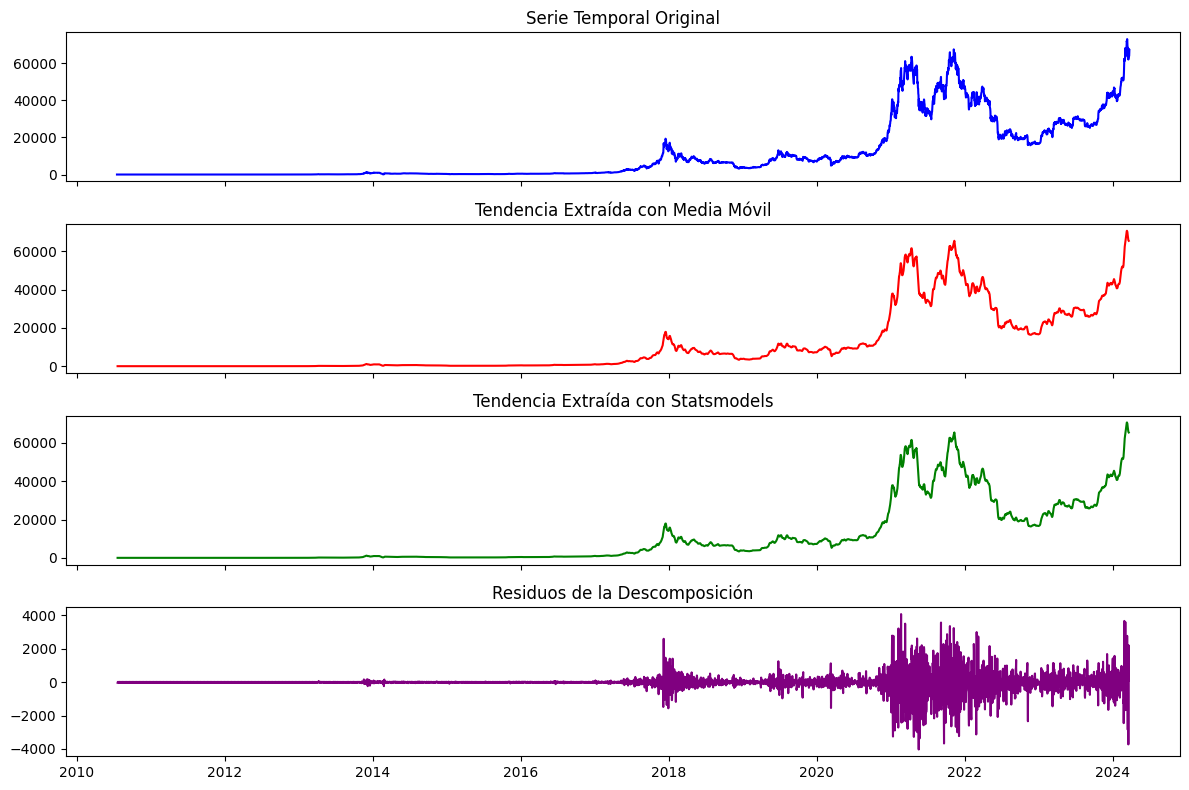


Prueba de Ljung-Box sobre los residuos:
        lb_stat      lb_pvalue
10  1026.374408  3.889671e-214


In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox

# -------------------------------------------
# 1. DESCOMPOSICIÓN USANDO MEDIAS MÓVILES
# -------------------------------------------
df['Trend_MA'] = df['Price'].rolling(window=7, center=True).mean()  # Media móvil de 7 días
df['Detrended_MA'] = df['Price'] - df['Trend_MA']  # Eliminando la tendencia

# -------------------------------------------
# 2. DESCOMPOSICIÓN USANDO STATSMODELS
# -------------------------------------------
decomp = seasonal_decompose(df['Price'], model='additive', period=7)  # Periodo de 7 días

# Extraer componentes
df['Trend_SM'] = decomp.trend
df['Seasonal_SM'] = decomp.seasonal
df['Residual_SM'] = decomp.resid

# -------------------------------------------
# 3. VERIFICACIÓN DE INDEPENDENCIA CON LJUNG-BOX
# -------------------------------------------
ljung_box_test = acorr_ljungbox(df['Residual_SM'].dropna(), lags=[10], return_df=True)

# -------------------------------------------
# 4. VISUALIZACIÓN DE LOS RESULTADOS
# -------------------------------------------
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
axes[0].plot(df['Price'], label="Serie Original", color='blue')
axes[0].set_title("Serie Temporal Original")
axes[1].plot(df['Trend_MA'], label="Tendencia (Media Móvil)", color='red')
axes[1].set_title("Tendencia Extraída con Media Móvil")
axes[2].plot(df['Trend_SM'], label="Tendencia (Statsmodels)", color='green')
axes[2].set_title("Tendencia Extraída con Statsmodels")
axes[3].plot(df['Residual_SM'], label="Residuos", color='purple')
axes[3].set_title("Residuos de la Descomposición")
plt.tight_layout()
plt.show()

# -------------------------------------------
# 5. RESULTADOS DE LJUNG-BOX
# -------------------------------------------
print("\nPrueba de Ljung-Box sobre los residuos:")
print(ljung_box_test)


Has compartido un gráfico que muestra la **descomposición de una serie temporal**. A continuación, se detallan los diferentes componentes mostrados en las gráficas:

1. **Serie Temporal Original (Azul):** Representa los datos originales de la serie temporal, en este caso, el precio de un activo (como Bitcoin) en función del tiempo. La serie muestra grandes oscilaciones y una tendencia general creciente con algunos picos.

2. **Tendencia Extraída con Media Móvil (Rojo):** Esta es la tendencia extraída usando una **media móvil**. La media móvil ayuda a suavizar las fluctuaciones y a mostrar la tendencia subyacente de la serie. A pesar de que las fluctuaciones siguen presentes, la línea muestra el comportamiento a largo plazo de la serie.

3. **Tendencia Extraída con Statsmodels (Verde):** La descomposición realizada mediante **Statsmodels** es otra forma de extraer la tendencia de la serie temporal. Statsmodels usa un enfoque basado en modelos de descomposición estacional, como el filtro de medias móviles, y otros métodos para separar la serie en componentes. A diferencia de la media móvil simple, esta técnica tiende a ser más precisa y puede capturar mejor las fluctuaciones estacionales y las tendencias.

4. **Residuos de la Descomposición (Morado):** Esta gráfica muestra los residuos o **componentes estocásticos** de la serie, que son las diferencias entre la serie original y la tendencia extraída. Los residuos deben ser aleatorios (sin estructura temporal aparente) para que la descomposición sea válida y pueda ser utilizada en modelos predictivos.

### Conclusión:
La descomposición de la serie temporal muestra cómo diferentes métodos (media móvil y modelos de descomposición como los de Statsmodels) pueden extraer la **tendencia subyacente** y cómo los **residuos** nos proporcionan información útil sobre las fluctuaciones no explicadas por la tendencia y la estacionalidad. La presencia de picos grandes en los residuos podría indicar **eventos atípicos** o **choques de mercado** en los datos.



In [33]:
import warnings
warnings.filterwarnings("ignore")
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, q_stat
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
 
# =========================================
# 1. Lectura de datos y limpieza
# =========================================

# Cargar datos
data_url = "https://raw.githubusercontent.com/lihkir/Data/refs/heads/main/Bitcoin%20Historical%20Data.csv"
df = pd.read_csv(data_url, parse_dates=['Date'], index_col='Date')
 
def parse_volume_str(vol_str):
    if not isinstance(vol_str, str):
        return vol_str
    vol_str = vol_str.replace(",", "").strip()
    if vol_str.endswith('K'):
        return float(vol_str[:-1]) * 1e3
    elif vol_str.endswith('M'):
        return float(vol_str[:-1]) * 1e6
    elif vol_str.endswith('B'):
        return float(vol_str[:-1]) * 1e9
    else:
        return float(vol_str)
 
df["Vol."] = df["Vol."].apply(parse_volume_str)
df["Change %"] = df["Change %"].astype(str).str.replace("%", "").astype(float)
df['Price'] = df['Price'].astype(str).str.replace(',', '').astype(float)
df['High'] = df['High'].astype(str).str.replace(',', '').astype(float)
df['Low'] = df['Low'].astype(str).str.replace(',', '').astype(float)
df['Open'] = df['Open'].astype(str).str.replace(',', '').astype(float)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4999 entries, 2024-03-24 to 2010-07-18
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     4999 non-null   float64
 1   Open      4999 non-null   float64
 2   High      4999 non-null   float64
 3   Low       4999 non-null   float64
 4   Vol.      4993 non-null   float64
 5   Change %  4999 non-null   float64
dtypes: float64(6)
memory usage: 273.4 KB


In [35]:
df["Return"] = df["Price"].pct_change()
df["Return"].iloc[0] = 0  # Reemplazar el primer NaN con 0
 
# Calcular el retorno acumulado diario
df["Cumulative Return"] = df["Return"].cumsum()
 
# Ventanas de tiempo para la volatilidad
windows = [7, 14, 21, 28]
 
# Calcular la volatilidad con ventanas móviles
for w in windows:
    df[f"Volatility_{w}d"] = df["Return"].rolling(window=w, min_periods=1).std()

In [36]:
df

,Price,Open,High,Low,Vol.,Change %,Return,Cumulative Return,Volatility_7d,Volatility_14d,Volatility_21d,Volatility_28d
Date,,,,,,,,,,,,
2024-03-24,67211.9,64036.5,67587.8,63812.9,65590.0,4.96,0.000000,0.000000,NaN,NaN,NaN,NaN
2024-03-23,64037.8,63785.6,65972.4,63074.9,35110.0,0.40,-0.047225,-0.047225,0.033393,0.033393,0.033393,0.033393
2024-03-22,63785.5,65501.5,66633.3,62328.3,72430.0,-2.62,-0.003940,-0.051165,0.026202,0.026202,0.026202,0.026202
2024-03-21,65503.8,67860.0,68161.7,64616.1,75260.0,-3.46,0.026939,-0.024226,0.030685,0.030685,0.030685,0.030685
2024-03-20,67854.0,62046.8,68029.5,60850.9,133530.0,9.35,0.035879,0.011652,0.032525,0.032525,0.032525,0.032525
...,...,...,...,...,...,...,...,...,...,...,...,...
2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.00,0.000000,-4.322978,0.000000,0.000000,0.000000,0.000000
2010-07-21,0.1,0.1,0.1,0.1,580.0,0.00,0.000000,-4.322978,0.000000,0.000000,0.000000,0.000000
2010-07-20,0.1,0.1,0.1,0.1,260.0,0.00,0.000000,-4.322978,0.000000,0.000000,0.000000,0.000000




### Campos:
1. **Price:** El precio de cierre del activo en la fecha correspondiente.
2. **Open:** El precio de apertura del activo en esa fecha.
3. **High:** El precio más alto alcanzado durante el día.
4. **Low:** El precio más bajo alcanzado durante el día.
5. **Vol.:** El volumen de operaciones (en términos de cantidad negociada).
6. **Change %:** El cambio porcentual del precio respecto al día anterior.
7. **Return:** El rendimiento en términos relativos del activo.
8. **Cumulative Return:** El rendimiento acumulado desde el inicio de la serie temporal.
9. **Volatility_7d, Volatility_14d, Volatility_21d, Volatility_28d:** La volatilidad medida en diferentes ventanas de tiempo (7, 14, 21 y 28 días). Mide la dispersión de los rendimientos en estos períodos.

### Datos destacables:
- El **Precio** muestra un comportamiento volátil con picos significativos en las últimas fechas (marzo de 2024), lo cual sugiere que el activo ha tenido movimientos importantes.
- La columna de **Change %** indica las variaciones diarias del precio. Por ejemplo, en **2024-03-24**, hubo un cambio significativo de **4.96%**, mientras que en fechas previas los cambios fueron menores, como **0.40%** el **2024-03-23**.
- **Volatilidad**: Las columnas de volatilidad muestran la variabilidad de los rendimientos en distintas ventanas. Los valores en las primeras filas de la serie temporal (como en **2010-07-22**) son **cero**, lo que puede indicar que el activo era muy poco volátil o que no se realizaban transacciones.
- **Cumulative Return** muestra un valor en crecimiento, lo que indica que el activo ha tenido una tendencia ascendente general desde su inicio.

### Posibles análisis a realizar:
- **Tendencia de precios:** Analizar cómo el precio del activo ha evolucionado a lo largo del tiempo.
- **Volatilidad:** Estudiar la relación entre los cambios de precio y la volatilidad a lo largo del tiempo, y cómo eso se correlaciona con eventos significativos.
- **Rendimientos:** Evaluar el rendimiento acumulado y los rendimientos diarios.

